In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

# Generate synthetic data

First, we create a regular grid of observation points.

In [2]:
sensor_sample_distance = 5.0  # µm
coordinates = vd.grid_coordinates(
    region=[-100, 600, -100, 600],  # µm
    spacing=2,  # µm
    extra_coords=sensor_sample_distance,
)


Now create the dipole model that will be used to generate the data.

In [3]:
sourcers1 = 5
sourcers2 = 5
np.random.seed(5)

dipole_coordinates = (
    np.concatenate([np.random.randint(30, 470, sourcers1),np.random.randint(30, 470, sourcers2), [250]]),  # µm
    np.concatenate([np.random.randint(30, 470, sourcers1),np.random.randint(30, 470, sourcers2), [250]]),  # µm
    np.concatenate([np.random.randint(-20, -1, sourcers1+sourcers2), [-20]]),  # µm
)
dipole_moments = mg.angles_to_vector(
    inclination=np.concatenate([np.random.normal(0, 10, sourcers1),np.random.normal(0, 10, sourcers2), [10]]),
    declination=np.concatenate([np.random.normal(0, 10, sourcers1),np.random.normal(180, 10, sourcers2), [10]]),
    amplitude=np.concatenate([abs(np.random.normal(0, 100, sourcers1+sourcers2))*1.0E-14, [5e-11]]),
)

# print(abs(np.random.normal(1.0E-14, 1.0E-12, sourcers)))
print(np.shape(dipole_moments))
print(np.shape(dipole_coordinates))



(11, 3)
(3, 11)


In [4]:
# bz_regional = mg.dipole_bz(coordinates, deep_dipole_coordinates, deep_dipole_moments)
bz = mg.dipole_bz(coordinates, dipole_coordinates, dipole_moments)
# data = vd.make_xarray_grid(coordinates, bz+bz_regional, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
data = vd.make_xarray_grid(coordinates, bz, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
data.x.attrs = {"units": "µm"}
data.y.attrs = {"units": "µm"}
data.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}
data

<xarray.Dataset>
Dimensions:  (y: 351, x: 351)
Coordinates:
  * x        (x) float64 -100.0 -98.0 -96.0 -94.0 ... 594.0 596.0 598.0 600.0
  * y        (y) float64 -100.0 -98.0 -96.0 -94.0 ... 594.0 596.0 598.0 600.0
    z        (y, x) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz       (y, x) float64 2.146 2.134 2.121 2.108 ... 12.68 12.55 12.42 12.29

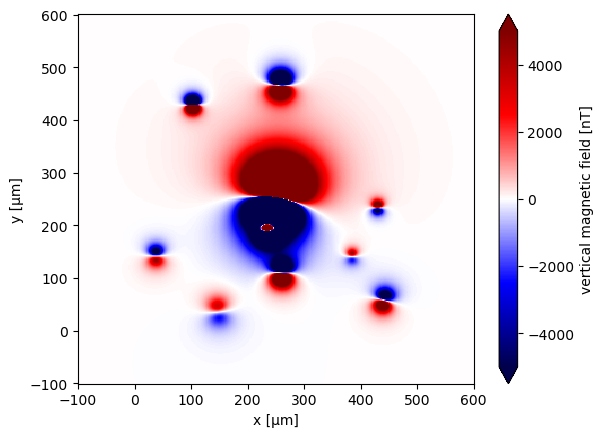

In [5]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=5000, vmin=-5000)

Add some random noise to make it more realistic.

In [6]:
noise_std_dev = 50  # nT
data.bz.values += mg.gaussian_noise(noise_std_dev, data.bz.shape, seed=42)

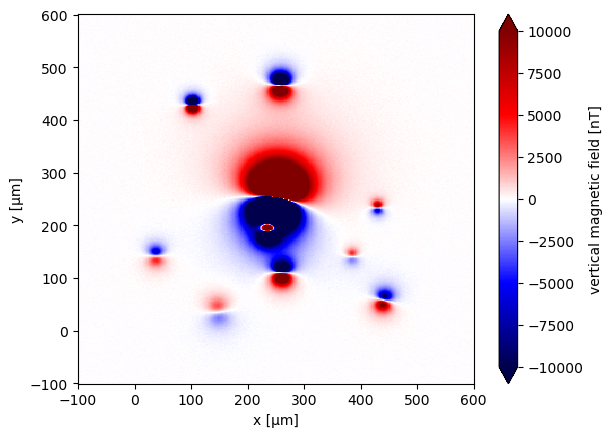

In [7]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Upward continue the data to suppress high frequency noise
2. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
3. Contrast stretch the TGA to highlight weaker sources
4. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

## 1. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [8]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
data_up

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 351, x: 351)
Coordinates:
  * y        (y) float64 -100.0 -98.0 -96.0 -94.0 ... 594.0 596.0 598.0 600.0
  * x        (x) float64 -100.0 -98.0 -96.0 -94.0 ... 594.0 596.0 598.0 600.0
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 8.017 9.073 9.826 8.847 ... 4.256 3.903 4.983 6.825

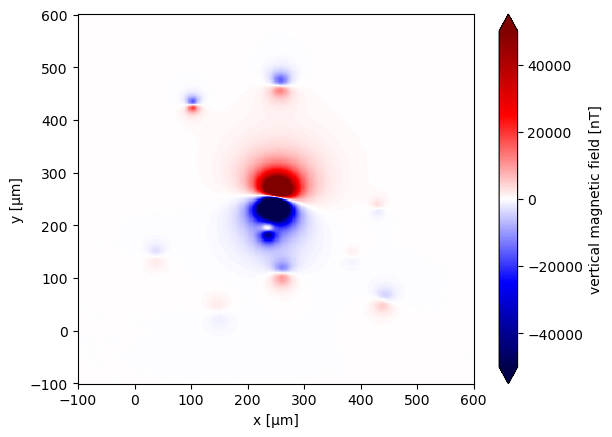

In [9]:
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=50000, vmin=-50000)

## 2. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [10]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 351, x: 351)
Coordinates:
  * y        (y) float64 -100.0 -98.0 -96.0 -94.0 ... 594.0 596.0 598.0 600.0
  * x        (x) float64 -100.0 -98.0 -96.0 -94.0 ... 594.0 596.0 598.0 600.0
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 8.017 9.073 9.826 8.847 ... 4.256 3.903 4.983 6.825
    tga      (y, x) float64 0.6775 0.6232 1.267 1.354 ... 1.707 1.296 0.9423
    x_deriv  (y, x) float64 0.5282 0.4522 -0.05659 ... 0.1817 0.7305 0.9208
    y_deriv  (y, x) float64 -0.333 -0.3705 -0.3703 ... -0.6649 -0.2621 -0.03645
    z_deriv  (y, x) float64 -0.2629 -0.2159 -1.211 -1.005 ... 1.561 1.038 0.1967

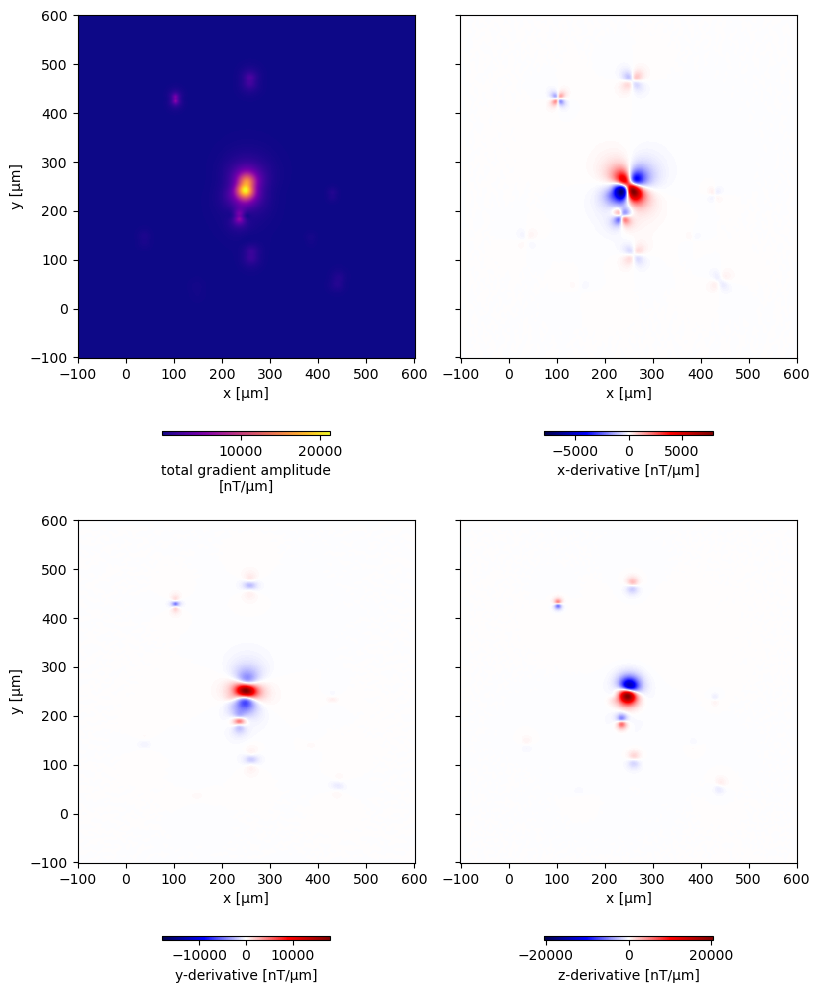

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
    else:
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 3. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [12]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (0.5, 99))),
)
data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

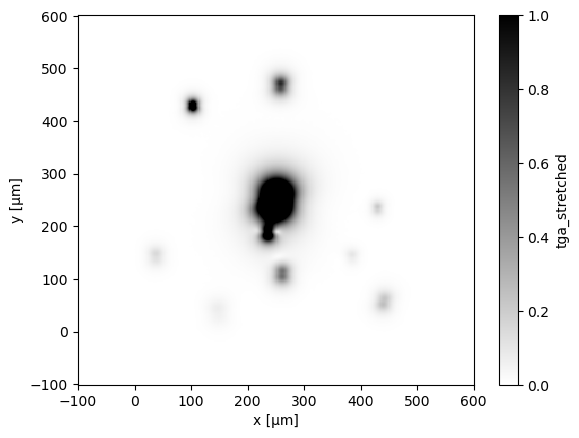

In [13]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 4. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [14]:
windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[20, 150],
    size_increment=1.5,
    threshold=0.01,
    overlap=0.3,
    exclude_border=15
)
# windows


In [15]:
print('Sources detected: ', np.shape(windows)[0])

Sources detected:  10


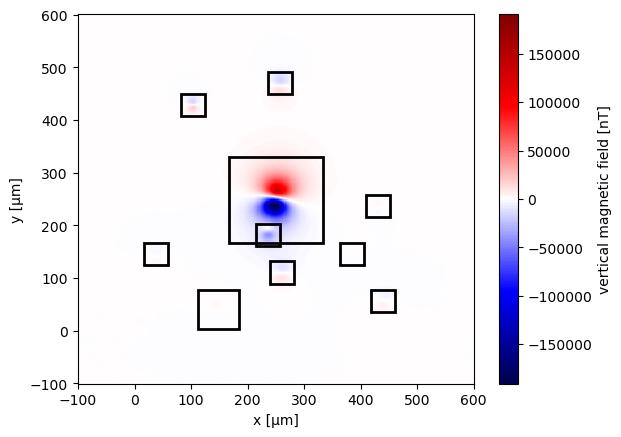

In [16]:
ax = plt.subplot(111)
data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion

Run the Euler Deconvolution and the inversion on each window.

In [17]:
positions = []
estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []
windows_filtered = []
base_levels = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    data_minus_background = anomaly.bz.values - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.data_minus_background, position,
    )
    
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False #r2 < 0.85 # False  

    if bad_euler or poor_fit:
        continue
    print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    positions.append(position)  
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    windows_filtered.append(window)
    base_levels.append(base_level)
positions = np.transpose(positions)

print()
print("Dipole moments estimated:", positions.shape[1])

R²: 0.9842206061074064 and SNR: 18.125526572659936 | -19.124200182984755
R²: 0.998847637267859 and SNR: 29.392696510287294 | -1.5958122882241266
R²: 0.4424791951101872 and SNR: 3.210479157444312 | 1.3924317623485094
R²: 0.9998611014179671 and SNR: 39.16720619518398 | -9.876020099424807
R²: 0.9950827420811582 and SNR: 23.177936801836868 | -12.376737108944727
R²: 0.9999023788445272 and SNR: 40.55450520908063 | -10.77023205704869
R²: 0.9972602630995226 and SNR: 25.638038714683994 | -4.961087942556676
R²: 0.9997686843058269 and SNR: 36.55631280105926 | -10.708939772155743
R²: 0.9620429511453682 and SNR: 14.635927253730339 | -7.82868741054975
R²: 0.9895811730840476 and SNR: 20.3213993004473 | -17.71655690393617

Dipole moments estimated: 10


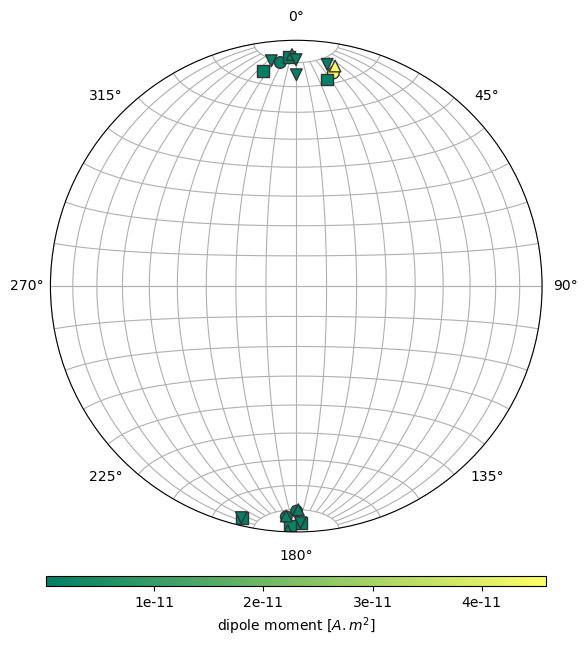

In [18]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
ax.grid()
estimated = mg.vector_to_angles(estimated_dipole_moments)
true = mg.vector_to_angles(dipole_moments)
scatter_args = dict(
    vmin=np.min([np.min(estimated[2]), np.min(true[2])]),
    vmax=np.min([np.max(estimated[2]), np.max(true[2])]),
    cmap="summer",
    edgecolors="#333333",
    linewidths=1,
    s=70,
    zorder=2,
)
pos_inc = estimated[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
    c=estimated[2][pos_inc],
    marker="o",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
    c=estimated[2][~pos_inc],
    marker="s",
    **scatter_args,
)
pos_inc = true[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(true[0][pos_inc], true[1][pos_inc]),
    c=true[2][pos_inc],
    marker="^",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-true[0][~pos_inc], true[1][~pos_inc]),
    c=true[2][~pos_inc],
    marker="v",
    **scatter_args,
)
fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.0e",
)
plt.show()

In [19]:
tree = sp.spatial.KDTree(np.transpose(dipole_coordinates))
closest = tree.query(np.transpose(positions))[1]
z_difference = positions[2] - np.array(dipole_coordinates[2])[closest]
z_difference

array([ 0.87579982,  0.40418771,  8.39243176,  0.1239799 , -1.37673711,
        0.22976794,  0.03891206,  0.29106023,  0.17131259,  1.2834431 ])

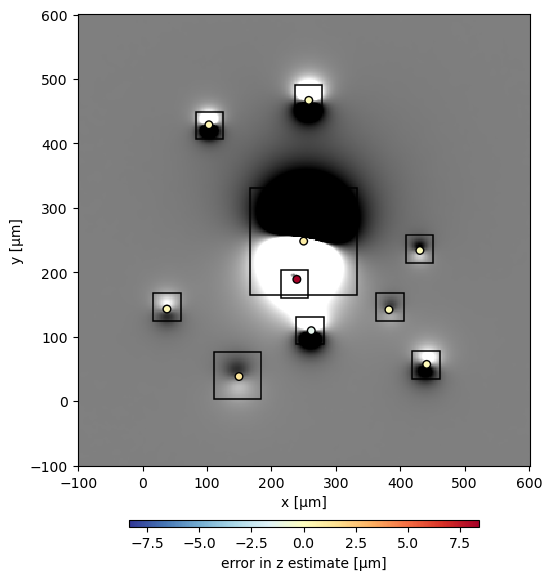

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.09, shrink=0.5)

data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
for window in windows_filtered:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)
scale = vd.maxabs(z_difference)
tmp = ax.scatter(*positions[:2], c=z_difference, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')
fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]")

ax.set_aspect("equal")
plt.tight_layout(w_pad=0, pad=0)

In [21]:
direction_misfit = []
magnetic_moment_misfit = []

for estimated, sigmas, true, r2, SNR in zip(estimated_dipole_moments, estimated_stds, dipole_moments[closest], calculated_r2, calculated_SNR):
    einc, edec, eamp = mg.vector_to_angles(estimated)
    inc, dec, amp = mg.vector_to_angles(true)
    sigma_inc, sigma_dec, sigma_amp = sigmas
    
    
    # Calculate misfits
    dir_misfit = float(np.degrees(mplstereonet.angular_distance(
                            mplstereonet.line(inc, dec), mplstereonet.line(einc, edec), bidirectional=False))) # degrees
    magm_mom_misfit = abs(float((amp-eamp)/amp)*100) # %
    
    direction_misfit.append(dir_misfit)
    magnetic_moment_misfit.append(magm_mom_misfit)
    
    print(f"Inclination: {inc} | {einc} ± {sigma_inc:.3f}")
    print(f"Declination: {dec} | {edec} ± {sigma_dec:.3f}")
    print(f"Amplitude  : {amp:e} | {eamp:e} ± {sigma_amp:.1e}")
    print(f"R²   : {r2:.5f} ")
    print(f"SNR  : {SNR:.5f} ")
    print(f"Direction Misfit  : {dir_misfit:.2f}° ")
    print(f"Magnetic Moment Misfit  : {magm_mom_misfit:.2f} %")
    print()

Inclination: 10.0 | 13.03164463033239 ± 0.065
Declination: 10.0 | 9.873622261534525 ± 0.092
Amplitude  : 5.000000e-11 | 4.592504e-11 ± 7.1e-14
R²   : 0.98422 
SNR  : 18.12553 
Direction Misfit  : 3.03° 
Magnetic Moment Misfit  : 8.15 %

Inclination: -4.225079291623943 | -4.11217258655071 ± 0.065
Declination: 178.98932388190758 | 178.82575739362971 ± 0.093
Amplitude  : 3.554385e-13 | 3.313989e-13 ± 5.4e-16
R²   : 0.99885 
SNR  : 29.39270 
Direction Misfit  : 0.20° 
Magnetic Moment Misfit  : 6.76 %

Inclination: 6.448475108927783 | 9.693742153170293 ± 1.931
Declination: -1.0593044205742326 | -4.085709578078242 ± 2.738
Amplitude  : 1.561532e-12 | 1.870811e-13 ± 8.8e-15
R²   : 0.44248 
SNR  : 3.21048 
Direction Misfit  : 4.42° 
Magnetic Moment Misfit  : 88.02 %

Inclination: 7.124212708765679 | 6.737368552790342 ± 0.020
Declination: -177.50782341435095 | -177.52739919984106 ± 0.032
Amplitude  : 1.291963e-12 | 1.282796e-12 ± 7.1e-16
R²   : 0.99986 
SNR  : 39.16721 
Direction Misfit  : 0.39°

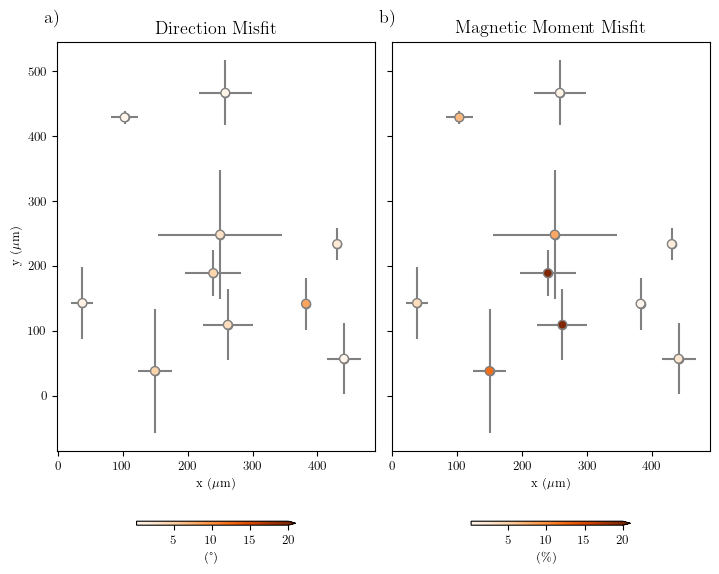

In [22]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

inc, dec, amp = mg.vector_to_angles(dipole_moments)
einc, edec, eamp = mg.vector_to_angles(estimated_dipole_moments)

scale_depth = (np.array(dipole_coordinates[2])[closest]/np.array(dipole_coordinates[2])[closest].max())*10
scale_amp= abs(np.log(np.array(amp)[closest])-np.log(np.array(amp)[closest]).min())*15

vmax=+10000
vmin=-10000

with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(1, 2, figsize=(7, 14), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.05, shrink=0.5)
    
    ax = axes[0]
    ax.set_aspect("equal")
    ax.set_title("Direction Misfit", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    

    scale = 20
    tmp = ax.scatter(*positions[:2], c=direction_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="(°)", **cbar_kwargs, extend='max') 
    ax.errorbar(*positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
    
    ax = axes[1]
    ax.set_aspect("equal")
    ax.set_title("Magnetic Moment Misfit", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")

    scale = 20
    tmp = ax.scatter(*positions[:2], c=magnetic_moment_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label=f"(\%)", **cbar_kwargs, extend='max') 
    ax.errorbar(*positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
  
    for ax, letter in zip(axes, "a b c d".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")

        
    plt.tight_layout(pad=0, h_pad=0, w_pad=0.5)
    
    plt.show()


# All sources Linear Problem

In [23]:
# derivatives for the original data
data = data.assign(mg.data_gradients(data.bz))
data

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 351, x: 351)
Coordinates:
  * x        (x) float64 -100.0 -98.0 -96.0 -94.0 ... 594.0 596.0 598.0 600.0
  * y        (y) float64 -100.0 -98.0 -96.0 -94.0 ... 594.0 596.0 598.0 600.0
    z        (y, x) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz       (y, x) float64 17.38 -49.87 39.64 49.14 ... -62.36 -32.16 -21.41
    tga      (y, x) float64 41.81 184.3 81.43 34.19 ... 207.9 35.88 91.11 196.9
    x_deriv  (y, x) float64 -33.62 5.566 24.75 -33.78 ... -25.39 10.24 5.378
    y_deriv  (y, x) float64 13.56 11.74 1.593 3.207 ... 5.002 -34.29 -25.61
    z_deriv  (y, x) float64 20.83 183.9 -77.56 -4.193 ... 24.86 83.78 195.2

In [24]:
x_concat = []
y_concat = []
z_concat = []
bz_concat = []
xc_concat = []
yc_concat = []
zc_concat = []
z_deriv_concat = []


for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    data_minus_background = anomaly.bz.values - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)
    
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
    print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    z_deriv_concat = np.append(z_deriv_concat, anomaly.z_deriv.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])

R²: 0.9842206061074064 and SNR: 18.125526572659936 | -19.124200182984755
R²: 0.998847637267859 and SNR: 29.392696510287294 | -1.5958122882241266
R²: 0.4424791951101872 and SNR: 3.210479157444312 | 1.3924317623485094
R²: 0.9998611014179671 and SNR: 39.16720619518398 | -9.876020099424807
R²: 0.9950827420811582 and SNR: 23.177936801836868 | -12.376737108944727
R²: 0.9999023788445272 and SNR: 40.55450520908063 | -10.77023205704869
R²: 0.9972602630995226 and SNR: 25.638038714683994 | -4.961087942556676
R²: 0.9997686843058269 and SNR: 36.55631280105926 | -10.708939772155743
R²: 0.9620429511453682 and SNR: 14.635927253730339 | -7.82868741054975
R²: 0.9895811730840476 and SNR: 20.3213993004473 | -17.71655690393617


In [25]:
x_concat = []
y_concat = []
z_concat = []
bz_concat = []
xc_concat = []
yc_concat = []
zc_concat = []
z_deriv_concat = []

data_copy = data.copy(deep=True)
data_up_copy = data_up.copy(deep=True)


for window in windows:
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    data_minus_background = anomaly.bz.values #- base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)
    
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard
    
#     print(discard.max())
    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
    print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    z_deriv_concat = np.append(z_deriv_concat, anomaly.z_deriv.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9844637361182038 and SNR: 18.12817327415713 | -19.124200182984755


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9988666609488668 and SNR: 29.543052211015564 | -1.5773320230057204


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9929700435892073 and SNR: 23.54118794702588 | -6.7590190143726305


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9998638828914063 and SNR: 39.12492756302785 | -9.736436109101158


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9995503432937635 and SNR: 35.39021978738451 | -10.912390625508804


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9999206884134483 and SNR: 41.15211429384526 | -10.778336238644295


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9994575785826532 and SNR: 33.63969678235062 | -4.6858797359500155


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9995267901813301 and SNR: 34.90665840237166 | -10.751655543344826


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9924328572993756 and SNR: 23.297440579213735 | -7.569986744589598


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9985520547897517 and SNR: 31.03283349588796 | -18.580646242758018


In [26]:
# print(data_copy)
# print(data)

In [27]:
all_coordinates = [x_concat, y_concat, z_concat]

np.shape(all_coordinates)

df = pd.DataFrame({'x':x_concat,
                   'y':y_concat,
                   'z':z_concat,
                  'bz':bz_concat,
                 'z_deriv':z_deriv_concat})#.set_index(['z'])

df['z_deriv']
# ds = df.to_xarray()

# ds

0       -52.051793
1       -54.523242
2       -57.601815
3       -61.340135
4       -64.766138
           ...    
11781    -0.294728
11782     0.612928
11783     1.280312
11784     0.926726
11785     0.784796
Name: z_deriv, Length: 11786, dtype: float64

In [28]:
all_positions = np.array([xc_concat, yc_concat, zc_concat])
print(all_positions)

[[250.07586859 102.99735038 235.44347603 257.9985023  261.06650198
  441.02210562 429.94881453  37.9699229  384.34250011 148.33669519]
 [248.35330587 429.00198659 188.06919859 466.93824453 109.94890682
   57.03774794 233.96907866 142.8984888  142.11952613  37.27042923]
 [-19.12420018  -1.57733202  -6.75901901  -9.73643611 -10.91239063
  -10.77833624  -4.68587974 -10.75165554  -7.56998674 -18.58064624]]


In [29]:
import numba
import choclo
import scipy
from micromag import TESLA_TO_NANOTESLA, MICROMETER_TO_METER

def all_dipole_moment_inversion(data, dipole_coordinates):
    
    data = data.to_xarray()
    
    n_data = len(data['bz']) #table.shape[0]
    n_params = len(dipole_coordinates[0])*3
    
    A = np.empty((n_data, n_params))
    
    d = np.array(data['bz']).ravel() / TESLA_TO_NANOTESLA #table.bz.values / TESLA_TO_NANOTESLA
    
    # Fill the Jacobian using a fast calculation with numba
    _dipole_jacobian_fast(
        data.x.values * MICROMETER_TO_METER,
        data.y.values * MICROMETER_TO_METER,
        data.z.values * MICROMETER_TO_METER,
        dipole_coordinates[0] * MICROMETER_TO_METER,
        dipole_coordinates[1] * MICROMETER_TO_METER,
        dipole_coordinates[2] * MICROMETER_TO_METER,
        A,
    )
    
    
    
    hessian = A.T @ A
    neg_gradient = A.T @ d
    dipole_moment = scipy.linalg.solve(hessian, neg_gradient, assume_a="pos")
    residuals = d - A @ dipole_moment
    
    dipole_moment = np.reshape(dipole_moment, (int(n_params/3), 3) )
    return dipole_moment 

@numba.jit(nopython=True, parallel=True)
def _dipole_jacobian_fast(e, n, u, de, dn, du, jacobian):
    """
    This is the bit that runs the fast for-loops
    """
    constant = choclo.constants.VACUUM_MAGNETIC_PERMEABILITY / (4 * np.pi)

    for j in numba.prange(len(de)):
        for i in numba.prange(len(e)):
            # Calculating the distance only once saves a lot of computation time
            distance = choclo.utils.distance_cartesian(
                e[i],
                n[i],
                u[i],
                de[j],
                dn[j],
                du[j],
            )
            # These are the second derivatives of 1/r
            jacobian[i, j*3] = constant * choclo.point.kernel_eu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            jacobian[i, j*3+1] = constant * choclo.point.kernel_nu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance=distance,
            )
            jacobian[i, j*3+2] = constant * choclo.point.kernel_uu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            


In [30]:
teste = all_dipole_moment_inversion(df, all_positions)
print(all_positions)

[[250.07586859 102.99735038 235.44347603 257.9985023  261.06650198
  441.02210562 429.94881453  37.9699229  384.34250011 148.33669519]
 [248.35330587 429.00198659 188.06919859 466.93824453 109.94890682
   57.03774794 233.96907866 142.8984888  142.11952613  37.27042923]
 [-19.12420018  -1.57733202  -6.75901901  -9.73643611 -10.91239063
  -10.77833624  -4.68587974 -10.75165554  -7.56998674 -18.58064624]]


In [31]:
# print(teste)

print(np.shape(estimated_dipole_moments))
print(np.shape(teste))

(10, 3)
(10, 3)


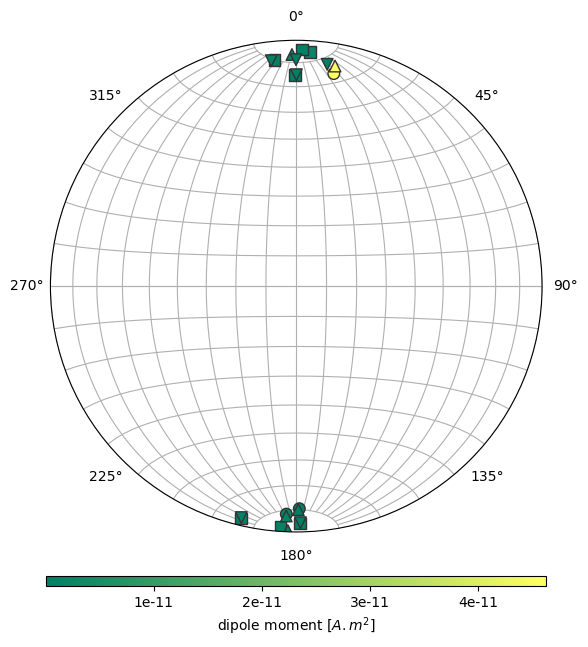

In [32]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
ax.grid()
estimated = mg.vector_to_angles(teste)
true = mg.vector_to_angles(dipole_moments)
scatter_args = dict(
    vmin=np.min([np.min(estimated[2]), np.min(true[2])]),
    vmax=np.min([np.max(estimated[2]), np.max(true[2])]),
    cmap="summer",
    edgecolors="#333333",
    linewidths=1,
    s=70,
    zorder=2,
)
pos_inc = estimated[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
    c=estimated[2][pos_inc],
    marker="o",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
    c=estimated[2][~pos_inc],
    marker="s",
    **scatter_args,
)
pos_inc = true[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(true[0][pos_inc], true[1][pos_inc]),
    c=true[2][pos_inc],
    marker="^",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-true[0][~pos_inc], true[1][~pos_inc]),
    c=true[2][~pos_inc],
    marker="v",
    **scatter_args,
)
fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.0e",
)
plt.show()

Compare the Euler Deconvolution estimated position on each window to the source true positions.

In [33]:
tree = sp.spatial.KDTree(np.transpose(dipole_coordinates))
closest = tree.query(np.transpose(all_positions))[1]
z_difference = all_positions[2] - np.array(dipole_coordinates[2])[closest]
z_difference

array([0.87579982, 0.42266798, 0.24098099, 0.26356389, 0.08760937,
       0.22166376, 0.31412026, 0.24834446, 0.43001326, 0.41935376])

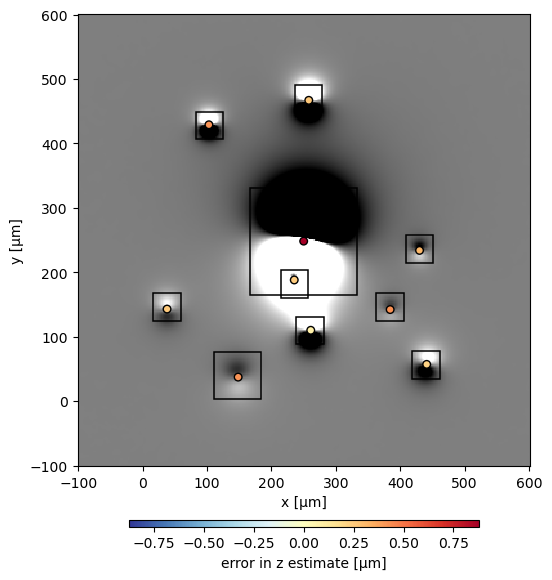

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.09, shrink=0.5)

data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
for window in windows_filtered:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)
scale = vd.maxabs(z_difference)
tmp = ax.scatter(*all_positions[:2], c=z_difference, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')
fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]")

ax.set_aspect("equal")
plt.tight_layout(w_pad=0, pad=0)

In [35]:
direction_misfit = []
magnetic_moment_misfit = []

for estimated, sigmas, true, r2, SNR in zip(teste, estimated_stds, dipole_moments[closest], calculated_r2, calculated_SNR):
    einc, edec, eamp = mg.vector_to_angles(estimated)
    inc, dec, amp = mg.vector_to_angles(true)
    sigma_inc, sigma_dec, sigma_amp = sigmas
    
    
    # Calculate misfits
    dir_misfit = float(np.degrees(mplstereonet.angular_distance(
                            mplstereonet.line(inc, dec), mplstereonet.line(einc, edec), bidirectional=False))) # degrees
    magm_mom_misfit = abs(float((amp-eamp)/amp)*100) # %
    
    direction_misfit.append(dir_misfit)
    magnetic_moment_misfit.append(magm_mom_misfit)
    
    print(f"Inclination: {inc} | {einc} ± {sigma_inc:.3f}")
    print(f"Declination: {dec} | {edec} ± {sigma_dec:.3f}")
    print(f"Amplitude  : {amp:e} | {eamp:e} ± {sigma_amp:.1e}")
    print(f"R²   : {r2:.5f} ")
    print(f"SNR  : {SNR:.5f} ")
    print(f"Direction Misfit  : {dir_misfit:.2f}° ")
    print(f"Magnetic Moment Misfit  : {magm_mom_misfit:.2f} %")
    print()

Inclination: 10.0 | 13.2337519927641 ± 0.065
Declination: 10.0 | 10.016621616197995 ± 0.092
Amplitude  : 5.000000e-11 | 4.633032e-11 ± 7.1e-14
R²   : 0.98422 
SNR  : 18.12553 
Direction Misfit  : 3.23° 
Magnetic Moment Misfit  : 7.34 %

Inclination: -4.225079291623943 | -3.7849689200054053 ± 0.065
Declination: 178.98932388190758 | 179.10472860666215 ± 0.093
Amplitude  : 3.554385e-13 | 3.288176e-13 ± 5.4e-16
R²   : 0.99885 
SNR  : 29.39270 
Direction Misfit  : 0.45° 
Magnetic Moment Misfit  : 7.49 %

Inclination: 6.448475108927783 | -5.274736718443082 ± 1.931
Declination: -1.0593044205742326 | 3.3252409715663704 ± 2.738
Amplitude  : 1.561532e-12 | 1.727820e-12 ± 8.8e-15
R²   : 0.44248 
SNR  : 3.21048 
Direction Misfit  : 12.51° 
Magnetic Moment Misfit  : 10.65 %

Inclination: 7.124212708765679 | 7.9424877082162 ± 0.020
Declination: -177.50782341435095 | -177.50828876518722 ± 0.032
Amplitude  : 1.291963e-12 | 1.255653e-12 ± 7.1e-16
R²   : 0.99986 
SNR  : 39.16721 
Direction Misfit  : 0.8

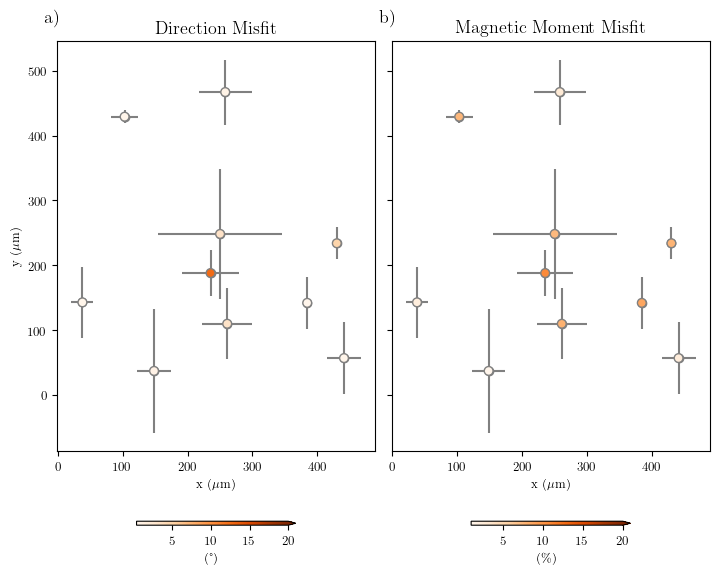

In [36]:
inc, dec, amp = mg.vector_to_angles(dipole_moments)
einc, edec, eamp = mg.vector_to_angles(teste)

scale_depth = (np.array(dipole_coordinates[2])[closest]/np.array(dipole_coordinates[2])[closest].max())*10
scale_amp= abs(np.log(np.array(amp)[closest])-np.log(np.array(amp)[closest]).min())*15

vmax=+10000
vmin=-10000

with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(1, 2, figsize=(7, 14), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.05, shrink=0.5)
    
    ax = axes[0]
    ax.set_aspect("equal")
    ax.set_title("Direction Misfit", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    

    scale = 20
    tmp = ax.scatter(*all_positions[:2], c=direction_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="(°)", **cbar_kwargs, extend='max') 
    ax.errorbar(*all_positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
    
    ax = axes[1]
    ax.set_aspect("equal")
    ax.set_title("Magnetic Moment Misfit", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")

    scale = 20
    tmp = ax.scatter(*all_positions[:2], c=magnetic_moment_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label=f"(\%)", **cbar_kwargs, extend='max') 
    ax.errorbar(*all_positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
        
    for ax, letter in zip(axes, "a b c d".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")

        
    plt.tight_layout(pad=0, h_pad=0, w_pad=0.5)
    

    plt.show()


### Show the observed and predicted data

In [37]:
predicted_data = mg.dipole_bz([coordinates[0], coordinates[1], data.z], all_positions, teste)
residuo = data.bz.values - predicted_data

In [38]:
data = data.assign(predicted_data=(['y','x'],predicted_data))
data.predicted_data.attrs = {"long_name": "predicted-data", "units": "nT"}

error = data.bz.values - data.predicted_data.values

data = data.assign(error=(['y','x'],error))
data.error.attrs = {"long_name": "residual-data", "units": "nT"}



In [39]:
data

<xarray.Dataset>
Dimensions:         (y: 351, x: 351)
Coordinates:
  * x               (x) float64 -100.0 -98.0 -96.0 -94.0 ... 596.0 598.0 600.0
  * y               (y) float64 -100.0 -98.0 -96.0 -94.0 ... 596.0 598.0 600.0
    z               (y, x) float64 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz              (y, x) float64 17.38 -49.87 39.64 ... -62.36 -32.16 -21.41
    tga             (y, x) float64 41.81 184.3 81.43 34.19 ... 35.88 91.11 196.9
    x_deriv         (y, x) float64 -33.62 5.566 24.75 ... -25.39 10.24 5.378
    y_deriv         (y, x) float64 13.56 11.74 1.593 ... 5.002 -34.29 -25.61
    z_deriv         (y, x) float64 20.83 183.9 -77.56 ... 24.86 83.78 195.2
    predicted_data  (y, x) float64 3.941 3.947 3.952 3.956 ... 13.33 13.19 13.06
    error           (y, x) float64 13.44 -53.81 35.69 ... -75.69 -45.35 -34.46

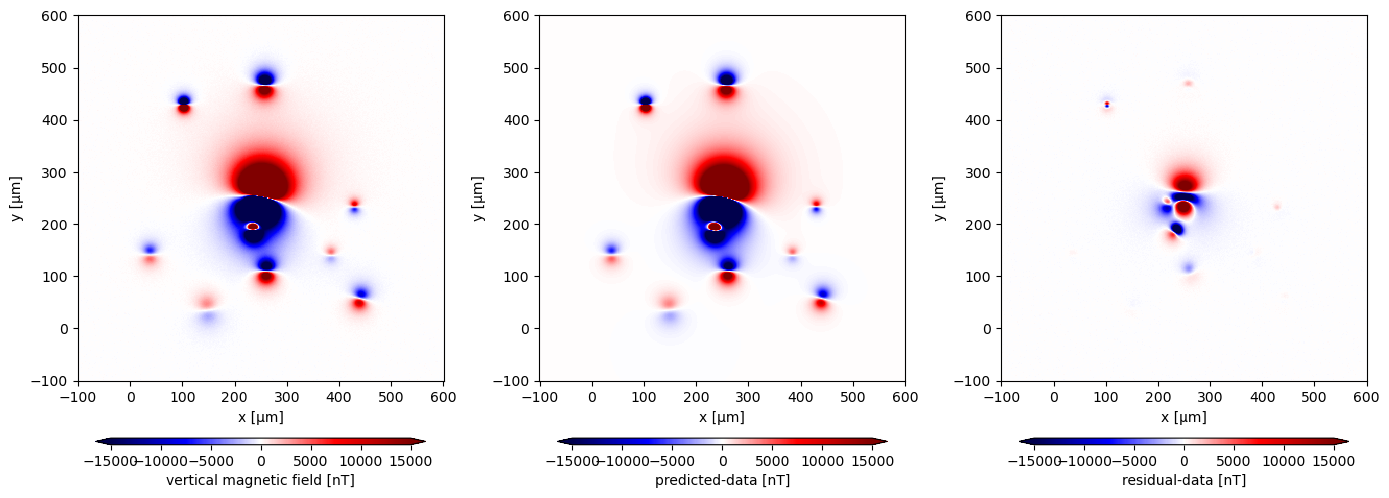

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.1, shrink=0.9)
for field, ax in zip(["bz", "predicted_data", "error"], axes.ravel()):
    vmax = +15000
    vmin = -15000
    data[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("equal")
plt.tight_layout()

### Show each window results
We displayed only the first 5 windows

0
All modeled sources: R2 = 0.9888108571254818 and SNR = 19.520315796141332


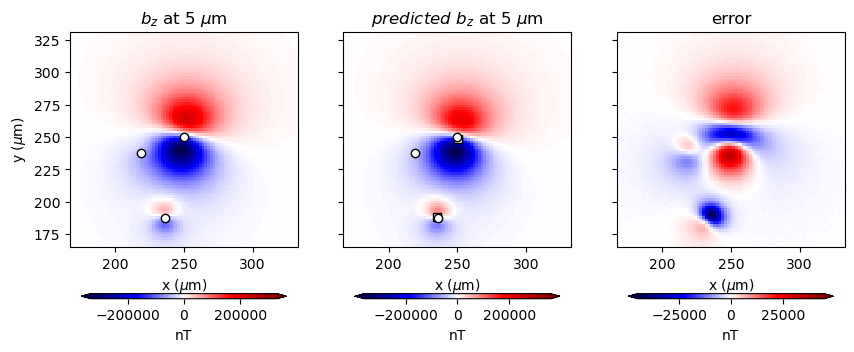

1
All modeled sources: R2 = 0.9936042293917966 and SNR = 21.948961174128996


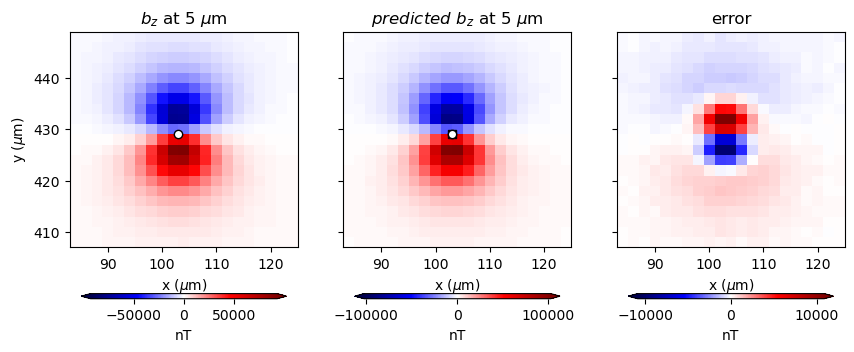

2
All modeled sources: R2 = 0.8083012298534503 and SNR = 7.915064578845408


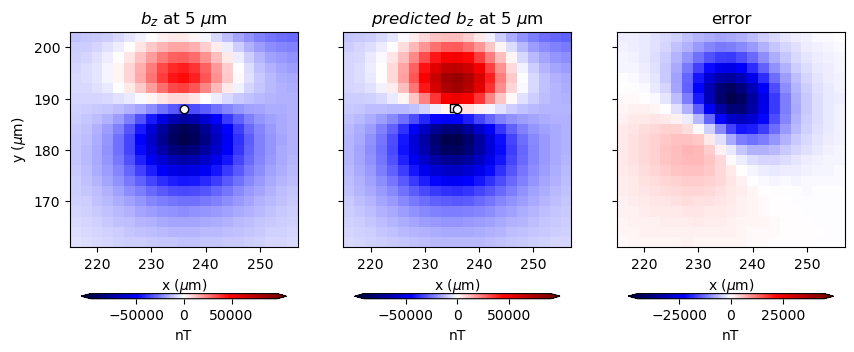

3
All modeled sources: R2 = 0.9988310182818868 and SNR = 29.754976664625037


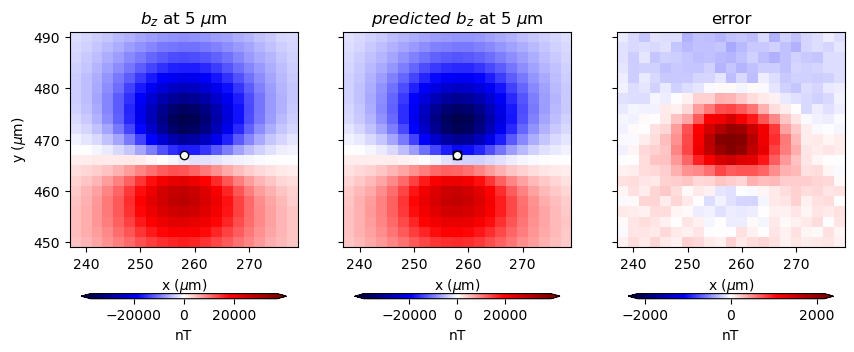

4
All modeled sources: R2 = 0.9902785035865417 and SNR = 21.122310190143505


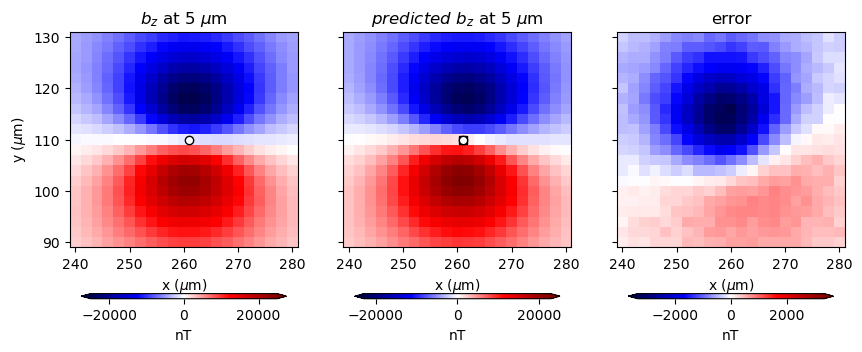

5
All modeled sources: R2 = 0.9996853975826648 and SNR = 35.28793254212803


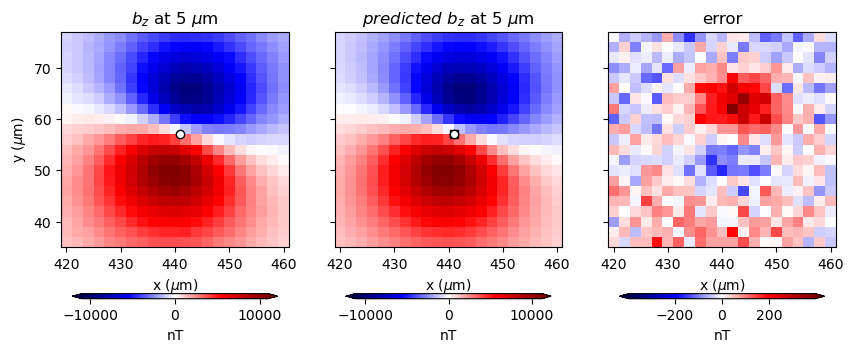

6
All modeled sources: R2 = 0.9873478533115084 and SNR = 19.26771010647523


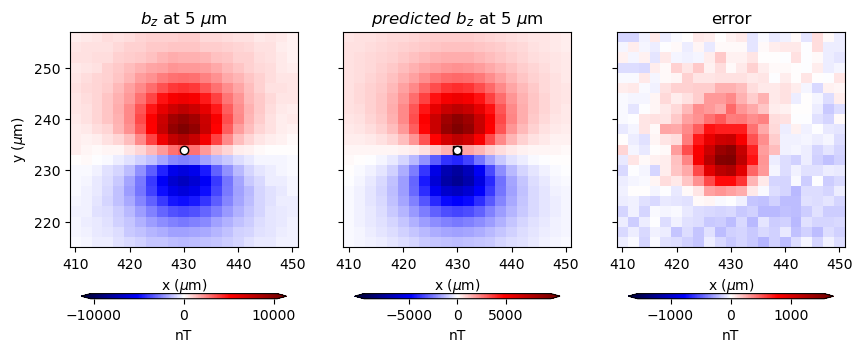

7
All modeled sources: R2 = 0.998650626876793 and SNR = 28.698988961174813


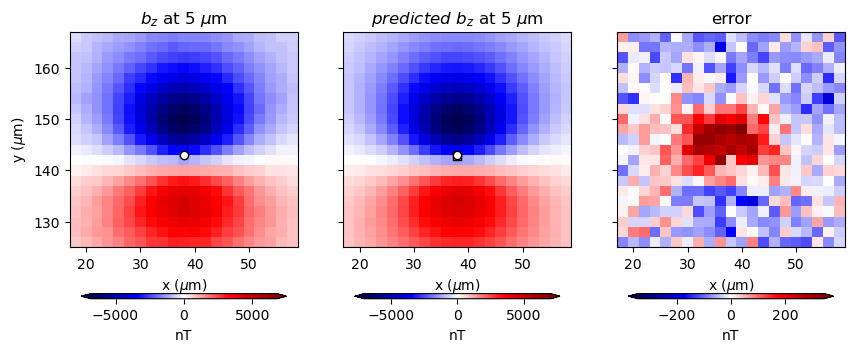

8
All modeled sources: R2 = 0.9923531235835042 and SNR = 21.529598830876484


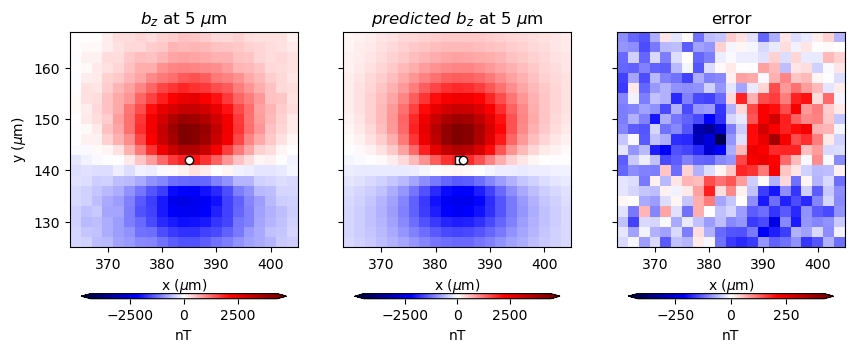

9
All modeled sources: R2 = 0.9956710845641812 and SNR = 23.775828581840265


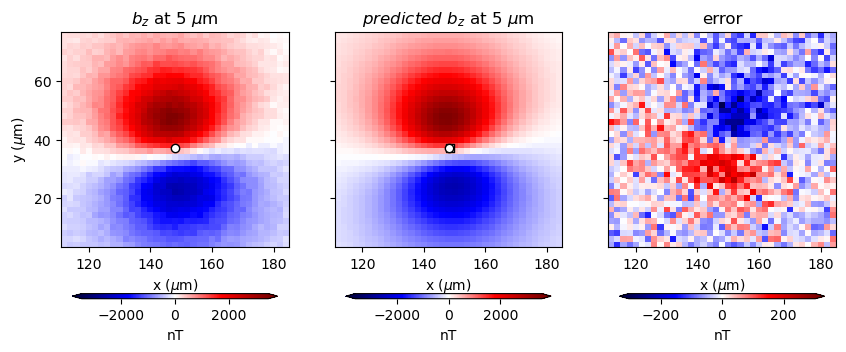

In [41]:
i = 0
for window in (windows_filtered):
    print(i)
    i += 1
    
    local_data = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9)
    
    ax = axes[0]
    ax.set_aspect("auto")
    ax.set_title(f"$b_z$ at {sensor_sample_distance:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = local_data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    ax.scatter(dipole_coordinates[0], dipole_coordinates[1], color='w', marker='o', edgecolors='k')
    
    ax = axes[1]
    ax.set_aspect("auto")
    ax.set_title(f"$predicted~b_z$ at {sensor_sample_distance:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = local_data.predicted_data.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    ax.scatter(all_positions[0], all_positions[1], color='w', marker='s', edgecolors='k')
    ax.scatter(dipole_coordinates[0], dipole_coordinates[1], color='w', marker='o', edgecolors='k')
    
    ax = axes[2]   
    ax.set_aspect("auto")
    ax.set_title("error")
    ax.set_xlabel("x ($\mu$m)")
    
    tmp = local_data.error.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
    residuals_sum_sq = np.sum((local_data.error.values)**2)
    r2_window = 1 - residuals_sum_sq / np.linalg.norm( np.array(local_data.bz.values) - float(local_data.bz.mean()) ) ** 2
    
    SNR_window = 10 * np.log10(np.var(local_data.bz.values, ddof=1) / np.var(local_data.error.values, ddof=1))
    
    # Compare R2 and SNR calculated with isolated windows and after calculating all sources contribution
    print(r"All modeled sources: R2 = %s and SNR = %s"%(r2_window, SNR_window))

    plt.show()

# Z-derivative inversion

\begin{equation}
\partial f_{zzz} = \dfrac{9\left(z-z_\text{c}\right)}{\left(\left(z-z_\text{c}\right)^2+\left(y-y_\text{c}\right)^2+\left(x-x_\text{c}\right)^2\right)^\frac{5}{2}}-\dfrac{15\left(z-z_\text{c}\right)^3}{\left(\left(z-z_\text{c}\right)^2+\left(y-y_\text{c}\right)^2+\left(x-x_\text{c}\right)^2\right)^\frac{7}{2}}
\end{equation}

\begin{equation}
\partial f_{xzz} = \dfrac{3\left(x-x_\text{c}\right)}{\left(\left(z-z_\text{c}\right)^2+\left(y-y_\text{c}\right)^2+\left(x-x_\text{c}\right)^2\right)^\frac{5}{2}}-\dfrac{15\left(x-x_\text{c}\right)\left(z-z_\text{c}\right)^2}{\left(\left(z-z_\text{c}\right)^2+\left(y-y_\text{c}\right)^2+\left(x-x_\text{c}\right)^2\right)^\frac{7}{2}}
\end{equation}

\begin{equation}
\partial f_{yzz} = \dfrac{3\left(y-y_\text{c}\right)}{\left(\left(z-z_\text{c}\right)^2+\left(y-y_\text{c}\right)^2+\left(x-x_\text{c}\right)^2\right)^\frac{5}{2}}-\dfrac{15\left(y-y_\text{c}\right)\left(z-z_\text{c}\right)^2}{\left(\left(z-z_\text{c}\right)^2+\left(y-y_\text{c}\right)^2+\left(x-x_\text{c}\right)^2\right)^\frac{7}{2}}
\end{equation}



Using:

\begin{equation}
\dfrac{\mu_0}{4\pi}
\begin{bmatrix}
\dfrac{\partial^2}{\partial z \partial x \partial z} \dfrac{1}{r_{1,1}}
& \dfrac{\partial^2}{\partial z \partial y \partial z} \dfrac{1}{r_{1,1}}
& \dfrac{\partial^2}{\partial z \partial z \partial z} \dfrac{1}{r_{1,1}}
& ...
& \dfrac{\partial^2}{\partial z \partial x \partial z} \dfrac{1}{r_{1,L}}
& \dfrac{\partial^2}{\partial z \partial y \partial z} \dfrac{1}{r_{1,L}}
& \dfrac{\partial^2}{\partial z \partial z \partial z} \dfrac{1}{r_{1,L}} \\
\\
& 
& 
& \vdots
& 
& 
&  \\
\\
\dfrac{\partial^2}{\partial z \partial x \partial z} \dfrac{1}{r_{N,1}}
& \dfrac{\partial^2}{\partial z \partial y \partial z} \dfrac{1}{r_{N,1}}
& \dfrac{\partial^2}{\partial z \partial z \partial z} \dfrac{1}{r_{N,1}}
& ...
& \dfrac{\partial^2}{\partial z \partial x \partial z} \dfrac{1}{r_{N,L}}
& \dfrac{\partial^2}{\partial z \partial y \partial z} \dfrac{1}{r_{N,L}}
& \dfrac{\partial^2}{\partial z \partial z \partial z} \dfrac{1}{r_{N,L}} \\
\end{bmatrix}
\begin{bmatrix}
{m_x}_1 \\ {m_y}_1 \\ {m_z}_1 \\ \vdots \\{m_x}_L \\ {m_y}_L \\ {m_z}_L \\
\end{bmatrix}
=
\begin{bmatrix}
\frac{\partial {b_z}_1}{\partial z} \\ \frac{\partial {b_z}_2}{\partial z} \\ \frac{\partial {b_z}_3}{\partial z} \\ \vdots \\\frac{\partial {b_z}_N}{\partial z}
\end{bmatrix}
\end{equation}


In [42]:
from numba import jit

@jit(nopython=True)
def kernel_uuu(
    easting_p, northing_p, upward_p, easting_q, northing_q, upward_q, distance
):
    r"""
    Second derivative of the inverse of the distance along upward-upward

    .. important ::

        The coordinates of the two points must be in Cartesian coordinates and
        have the same units.

    Parameters
    ----------
    easting_p : float
        Easting coordinate of point :math:`\mathbf{p}`.
    northing_p : float
        Northing coordinate of point :math:`\mathbf{p}`.
    upward_p : float
        Upward coordinate of point :math:`\mathbf{p}`.
    easting_q : float
        Easting coordinate of point :math:`\mathbf{q}`.
    northing_q : float
        Northing coordinate of point :math:`\mathbf{q}`.
    upward_q : float
        Upward coordinate of point :math:`\mathbf{q}`.
    distance : float
        Euclidean distance between points :math:`\mathbf{p}` and
        :math:`\mathbf{q}`.

    Returns
    -------
    kernel : float
        Value of the kernel function.


    """
    return 9 * (upward_p - upward_q) / distance**5 - 15 * (upward_p - upward_q)**3 / distance**7



@jit(nopython=True)
def kernel_euu(
    easting_p, northing_p, upward_p, easting_q, northing_q, upward_q, distance
):
    r"""
    Second derivative of the inverse of the distance along easting-upward

    .. important ::

        The coordinates of the two points must be in Cartesian coordinates and
        have the same units.

    Parameters
    ----------
    easting_p : float
        Easting coordinate of point :math:`\mathbf{p}`.
    northing_p : float
        Northing coordinate of point :math:`\mathbf{p}`.
    upward_p : float
        Upward coordinate of point :math:`\mathbf{p}`.
    easting_q : float
        Easting coordinate of point :math:`\mathbf{q}`.
    northing_q : float
        Northing coordinate of point :math:`\mathbf{q}`.
    upward_q : float
        Upward coordinate of point :math:`\mathbf{q}`.
    distance : float
        Euclidean distance between points :math:`\mathbf{p}` and
        :math:`\mathbf{q}`.

    Returns
    -------
    kernel : float
        Value of the kernel function.
    """
    return (  3 *  (easting_p - easting_q) / distance**5 
            - 15 * (easting_p - easting_q) * (upward_p - upward_q)**2 / distance**7)


@jit(nopython=True)
def kernel_nuu(
    easting_p, northing_p, upward_p, easting_q, northing_q, upward_q, distance
):
    r"""
    Second derivative of the inverse of the distance along easting-upward

    .. important ::

        The coordinates of the two points must be in Cartesian coordinates and
        have the same units.

    Parameters
    ----------
    easting_p : float
        Easting coordinate of point :math:`\mathbf{p}`.
    northing_p : float
        Northing coordinate of point :math:`\mathbf{p}`.
    upward_p : float
        Upward coordinate of point :math:`\mathbf{p}`.
    easting_q : float
        Easting coordinate of point :math:`\mathbf{q}`.
    northing_q : float
        Northing coordinate of point :math:`\mathbf{q}`.
    upward_q : float
        Upward coordinate of point :math:`\mathbf{q}`.
    distance : float
        Euclidean distance between points :math:`\mathbf{p}` and
        :math:`\mathbf{q}`.

    Returns
    -------
    kernel : float
        Value of the kernel function.
    """
    return (  3 *  (northing_p - northing_q) / distance**5 
            - 15 * (northing_p - northing_q) * (upward_p - upward_q)**2 / distance**7)

In [43]:
# def z_deriv_dipole_moment_inversion(data, dipole_coordinates):
#     """
#     Estimate the dipole moment through linear inversion.

#     Parameters
#     ----------
#     data : xarray.DataArray
#         The observed vertical magnetic field grid. Must have x, y, and z as
#         coordinates.
#     dipole_coordinates : 1D array
#         The (x, y, z) coordinates of the dipole.

#     Returns
#     -------
#     dipole_moment : 1D array
#         The estimated dipole moment vector.
#     covariance : 2D array
#         The estimated covariance matrix of the dipole moment vector.
#     r2 : float
#         The R² coefficient of determination of the inversion.
#     """
#     # Make it a dataset so we can be sure the variable name is "bz"
#     table = vd.grid_to_table(data.to_dataset(name="z_deriv"))
#     # Verde drops non-dimension coordinates so we have to add z back.
#     # This is a bug in Verde.
#     table["z"] = data.z.values.ravel()
#     n_data = table.shape[0]
#     n_params = 3
#     A = np.empty((n_data, n_params))
#     d = table.z_deriv.values / TESLA_TO_NANOTESLA
#     # Fill the Jacobian using a fast calculation with numba
#     _dipole_jacobian_fast(
#         table.x.values * MICROMETER_TO_METER,
#         table.y.values * MICROMETER_TO_METER,
#         table.z.values * MICROMETER_TO_METER,
#         dipole_coordinates[0] * MICROMETER_TO_METER,
#         dipole_coordinates[1] * MICROMETER_TO_METER,
#         dipole_coordinates[2] * MICROMETER_TO_METER,
#         A,
#     )
#     hessian = A.T @ A
#     neg_gradient = A.T @ d
#     dipole_moment = scipy.linalg.solve(hessian, neg_gradient, assume_a="pos")
#     residuals = d - A @ dipole_moment
#     residuals_sum_sq = np.sum(residuals**2)
#     # Estimate of the true error variance (since we'll never know it)
#     chi_squared = residuals_sum_sq / (n_data - n_params)
#     covariance = chi_squared * np.linalg.inv(hessian)
#     # R² Coeficient of Determination (dimensionless)
#     r2 = 1 - residuals_sum_sq / np.linalg.norm(d - d.mean()) ** 2
#     # signal-to-noise ratio in decibels (dB)
#     SNR = 10 * np.log10(np.var(d, ddof=1) / np.var(residuals, ddof=1)) 
#     return dipole_moment, covariance, r2, SNR


# @numba.jit(nopython=True, parallel=True)
# def _dipole_jacobian_fast(e, n, u, de, dn, du, jacobian):
#     """
#     This is the bit that runs the fast for-loops
#     """
#     constant = choclo.constants.VACUUM_MAGNETIC_PERMEABILITY / (4 * np.pi)
#     for i in numba.prange(e.size):
#         # Calculating the distance only once saves a lot of computation time
#         distance = choclo.utils.distance_cartesian(
#             e[i],
#             n[i],
#             u[i],
#             de,
#             dn,
#             du,
#         )
#         # These are the second derivatives of 1/r
#         jacobian[i, 0] = constant * kernel_euu(
#             easting_p=e[i],
#             northing_p=n[i],
#             upward_p=u[i],
#             easting_q=de,
#             northing_q=dn,
#             upward_q=du,
#             distance=distance,
#         )
#         jacobian[i, 1] = constant * kernel_nuu(
#             easting_p=e[i],
#             northing_p=n[i],
#             upward_p=u[i],
#             easting_q=de,
#             northing_q=dn,
#             upward_q=du,
#             distance=distance,
#         )
#         jacobian[i, 2] = constant * kernel_uuu(
#             easting_p=e[i],
#             northing_p=n[i],
#             upward_p=u[i],
#             easting_q=de,
#             northing_q=dn,
#             upward_q=du,
#             distance=distance,
#         )

def z_deriv_all_dipole_moment_inversion(data, dipole_coordinates):
    
    data = data.to_xarray()
    
    n_data = len(data['z_deriv']) #table.shape[0]
    n_params = len(dipole_coordinates[0])*3
    
    A = np.empty((n_data, n_params))
    
    d = np.array(data['z_deriv']).ravel() #*-1.0e-3 # CONVERTING nT/microm to T/m
    
    # Fill the Jacobian using a fast calculation with numba
    _dipole_jacobian_fast(
        data.x.values * MICROMETER_TO_METER,
        data.y.values * MICROMETER_TO_METER,
        data.z.values * MICROMETER_TO_METER,
        dipole_coordinates[0] * MICROMETER_TO_METER,
        dipole_coordinates[1] * MICROMETER_TO_METER,
        dipole_coordinates[2] * MICROMETER_TO_METER,
        A,
    )
    
    
    
    hessian = A.T @ A
    neg_gradient = A.T @ d
    dipole_moment = scipy.linalg.solve(hessian, neg_gradient, assume_a="pos")
    residuals = d - A @ dipole_moment
    
    dipole_moment = np.reshape(dipole_moment, (int(n_params/3), 3) )
    return dipole_moment * 1.0e-3


@numba.jit(nopython=True, parallel=True)
def _dipole_jacobian_fast(e, n, u, de, dn, du, jacobian):
    """
    This is the bit that runs the fast for-loops
    """
    constant = choclo.constants.VACUUM_MAGNETIC_PERMEABILITY / (4 * np.pi)

    for j in numba.prange(len(de)):
        for i in numba.prange(len(e)):
            # Calculating the distance only once saves a lot of computation time
            distance = choclo.utils.distance_cartesian(
                e[i],
                n[i],
                u[i],
                de[j],
                dn[j],
                du[j],
            )
            # These are the second derivatives of 1/r
            jacobian[i, j*3] = constant*kernel_euu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            jacobian[i, j*3+1] = constant*kernel_nuu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance=distance,
            )
            jacobian[i, j*3+2] = constant*kernel_uuu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            

In [44]:
teste2 = z_deriv_all_dipole_moment_inversion(df, all_positions)

In [45]:
print(teste)
print(teste2)

[[ 7.84441358e-12  4.44125347e-11 -1.06061376e-11]
 [ 5.12650224e-15 -3.28060339e-13  2.17059513e-14]
 [ 9.97957970e-14  1.71760690e-12  1.58841180e-13]
 [-5.40656586e-14 -1.24243167e-12 -1.73504848e-13]
 [-6.91518519e-14 -1.04640817e-12  3.76971346e-14]
 [-1.11257850e-13 -4.68496253e-13  2.66912082e-14]
 [ 2.32990386e-15  9.26959391e-14  6.77695052e-15]
 [ 3.58556070e-15 -2.59394775e-13 -4.74884321e-14]
 [-4.71865811e-16  7.65577174e-14  2.06984512e-14]
 [-4.46009265e-14  4.65677430e-13  6.97427824e-14]]
[[ 7.73095016e-12  4.28488791e-11 -1.16035327e-11]
 [ 5.97788266e-15 -3.34337133e-13  2.46352782e-14]
 [-4.45809377e-14  1.52583133e-12 -1.82390427e-13]
 [-5.45965445e-14 -1.25406546e-12 -1.49423199e-13]
 [-3.56516816e-14 -1.15503910e-12 -2.45738093e-14]
 [-1.11746318e-13 -4.72901026e-13  2.85710689e-14]
 [ 1.15230338e-16  9.65533671e-14  1.43611156e-14]
 [ 1.91330236e-15 -2.60920611e-13 -4.48704893e-14]
 [ 3.50353923e-15  7.83411857e-14  2.03536096e-14]
 [-5.35598007e-14  4.46958184e

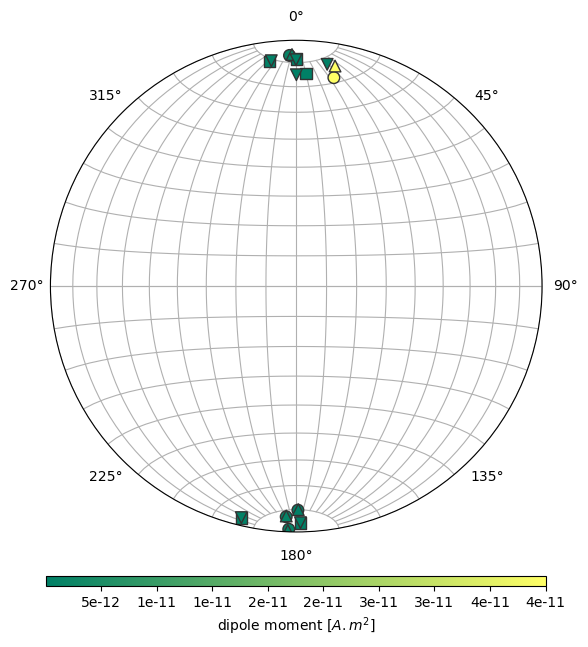

In [46]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
ax.grid()
estimated = mg.vector_to_angles(teste2)
true = mg.vector_to_angles(dipole_moments)
scatter_args = dict(
    vmin=np.min([np.min(estimated[2]), np.min(true[2])]),
    vmax=np.min([np.max(estimated[2]), np.max(true[2])]),
    cmap="summer",
    edgecolors="#333333",
    linewidths=1,
    s=70,
    zorder=2,
)
pos_inc = estimated[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
    c=estimated[2][pos_inc],
    marker="o",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
    c=estimated[2][~pos_inc],
    marker="s",
    **scatter_args,
)
pos_inc = true[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(true[0][pos_inc], true[1][pos_inc]),
    c=true[2][pos_inc],
    marker="^",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-true[0][~pos_inc], true[1][~pos_inc]),
    c=true[2][~pos_inc],
    marker="v",
    **scatter_args,
)
fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.0e",
)
plt.show()

In [47]:
direction_misfit = []
magnetic_moment_misfit = []

for estimated, sigmas, true, r2, SNR in zip(teste2, estimated_stds, dipole_moments[closest], calculated_r2, calculated_SNR):
    einc, edec, eamp = mg.vector_to_angles(estimated)
    inc, dec, amp = mg.vector_to_angles(true)
    sigma_inc, sigma_dec, sigma_amp = sigmas
    
    
    # Calculate misfits
    dir_misfit = float(np.degrees(mplstereonet.angular_distance(
                            mplstereonet.line(inc, dec), mplstereonet.line(einc, edec), bidirectional=False))) # degrees
    magm_mom_misfit = abs(float((amp-eamp)/amp)*100) # %
    
    direction_misfit.append(dir_misfit)
    magnetic_moment_misfit.append(magm_mom_misfit)
    
    print(f"Inclination: {inc} | {einc} ")
    print(f"Declination: {dec} | {edec} ")
    print(f"Amplitude  : {amp:e} | {eamp:e} ")
    print(f"Direction Misfit  : {dir_misfit:.2f}° ")
    print(f"Magnetic Moment Misfit  : {magm_mom_misfit:.2f} %")
    print()

Inclination: 10.0 | 14.922417535505453 
Declination: 10.0 | 10.227482269955702 
Amplitude  : 5.000000e-11 | 4.506036e-11 
Direction Misfit  : 4.93° 
Magnetic Moment Misfit  : 9.88 %

Inclination: -4.225079291623943 | -4.213492250118427 
Declination: 178.98932388190758 | 178.97567179578087 
Amplitude  : 3.554385e-13 | 3.352968e-13 
Direction Misfit  : 0.02° 
Magnetic Moment Misfit  : 5.67 %

Inclination: 6.448475108927783 | 6.813633986021258 
Declination: -1.0593044205742326 | -1.6735618621040418 
Amplitude  : 1.561532e-12 | 1.537340e-12 
Direction Misfit  : 0.71° 
Magnetic Moment Misfit  : 1.55 %

Inclination: 7.124212708765679 | 6.788446984081802 
Declination: -177.50782341435095 | -177.50716560203819 
Amplitude  : 1.291963e-12 | 1.264116e-12 
Direction Misfit  : 0.34° 
Magnetic Moment Misfit  : 2.16 %

Inclination: 0.591442432190399 | 1.21822131737967 
Declination: -178.02339908957504 | -178.23205764462188 
Amplitude  : 1.139343e-12 | 1.155850e-12 
Direction Misfit  : 0.66° 
Magnetic

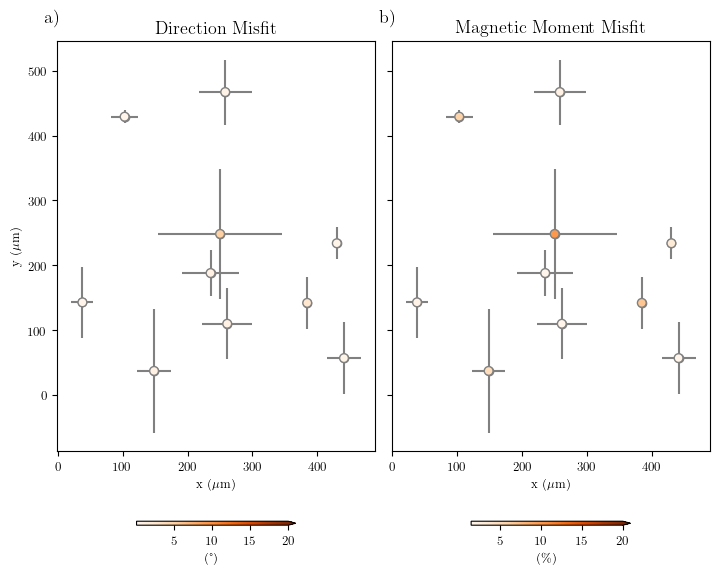

In [48]:
inc, dec, amp = mg.vector_to_angles(dipole_moments)
einc, edec, eamp = mg.vector_to_angles(teste2)

scale_depth = (np.array(dipole_coordinates[2])[closest]/np.array(dipole_coordinates[2])[closest].max())*10
scale_amp= abs(np.log(np.array(amp)[closest])-np.log(np.array(amp)[closest]).min())*15

vmax=+10000
vmin=-10000

with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(1, 2, figsize=(7, 14), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.05, shrink=0.5)
    
    ax = axes[0]
    ax.set_aspect("equal")
    ax.set_title("Direction Misfit", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    

    scale = 20
    tmp = ax.scatter(*all_positions[:2], c=direction_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="(°)", **cbar_kwargs, extend='max') 
    ax.errorbar(*all_positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
    
    ax = axes[1]
    ax.set_aspect("equal")
    ax.set_title("Magnetic Moment Misfit", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")

    scale = 20
    tmp = ax.scatter(*all_positions[:2], c=magnetic_moment_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label=f"(\%)", **cbar_kwargs, extend='max') 
    ax.errorbar(*all_positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
        
    for ax, letter in zip(axes, "a b c d".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")

        
    plt.tight_layout(pad=0, h_pad=0, w_pad=0.5)
    

    plt.show()


In [49]:
data

<xarray.Dataset>
Dimensions:         (y: 351, x: 351)
Coordinates:
  * x               (x) float64 -100.0 -98.0 -96.0 -94.0 ... 596.0 598.0 600.0
  * y               (y) float64 -100.0 -98.0 -96.0 -94.0 ... 596.0 598.0 600.0
    z               (y, x) float64 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz              (y, x) float64 17.38 -49.87 39.64 ... -62.36 -32.16 -21.41
    tga             (y, x) float64 41.81 184.3 81.43 34.19 ... 35.88 91.11 196.9
    x_deriv         (y, x) float64 -33.62 5.566 24.75 ... -25.39 10.24 5.378
    y_deriv         (y, x) float64 13.56 11.74 1.593 ... 5.002 -34.29 -25.61
    z_deriv         (y, x) float64 20.83 183.9 -77.56 ... 24.86 83.78 195.2
    predicted_data  (y, x) float64 3.941 3.947 3.952 3.956 ... 13.33 13.19 13.06
    error           (y, x) float64 13.44 -53.81 35.69 ... -75.69 -45.35 -34.46

### Show the observed and predicted data

In [50]:
predicted_data = mg.dipole_bz([coordinates[0], coordinates[1], data.z], all_positions, teste2)
residuo = data.bz.values - predicted_data

In [51]:
data = data.assign(predicted_data=(['y','x'],predicted_data))
data.predicted_data.attrs = {"long_name": "predicted-data", "units": "nT"}

error = data.bz.values - data.predicted_data.values

data = data.assign(error=(['y','x'],error))
data.error.attrs = {"long_name": "residual-data", "units": "nT"}

In [52]:
data

<xarray.Dataset>
Dimensions:         (y: 351, x: 351)
Coordinates:
  * x               (x) float64 -100.0 -98.0 -96.0 -94.0 ... 596.0 598.0 600.0
  * y               (y) float64 -100.0 -98.0 -96.0 -94.0 ... 596.0 598.0 600.0
    z               (y, x) float64 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz              (y, x) float64 17.38 -49.87 39.64 ... -62.36 -32.16 -21.41
    tga             (y, x) float64 41.81 184.3 81.43 34.19 ... 35.88 91.11 196.9
    x_deriv         (y, x) float64 -33.62 5.566 24.75 ... -25.39 10.24 5.378
    y_deriv         (y, x) float64 13.56 11.74 1.593 ... 5.002 -34.29 -25.61
    z_deriv         (y, x) float64 20.83 183.9 -77.56 ... 24.86 83.78 195.2
    predicted_data  (y, x) float64 5.402 5.422 5.442 5.462 ... 14.16 14.02 13.88
    error           (y, x) float64 11.98 -55.29 34.2 ... -76.52 -46.18 -35.29

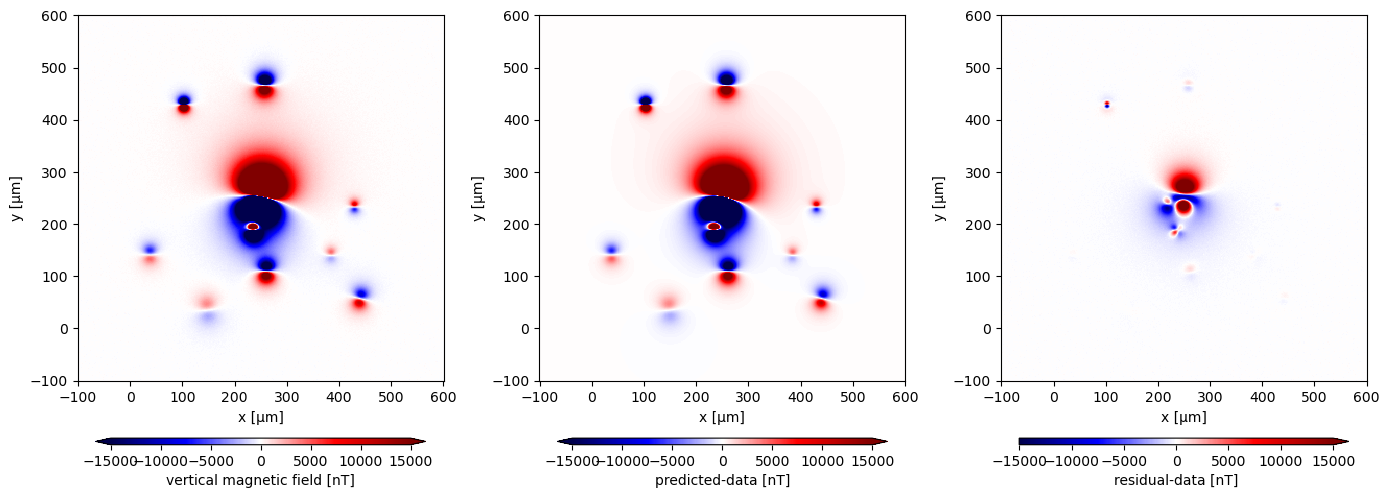

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.1, shrink=0.9)
for field, ax in zip(["bz", "predicted_data", "error"], axes.ravel()):
    vmax = +15000
    vmin = -15000
    data[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("equal")
plt.tight_layout()

0
All modeled sources: R2 = 0.9906030223147781 and SNR = 20.33267026610916


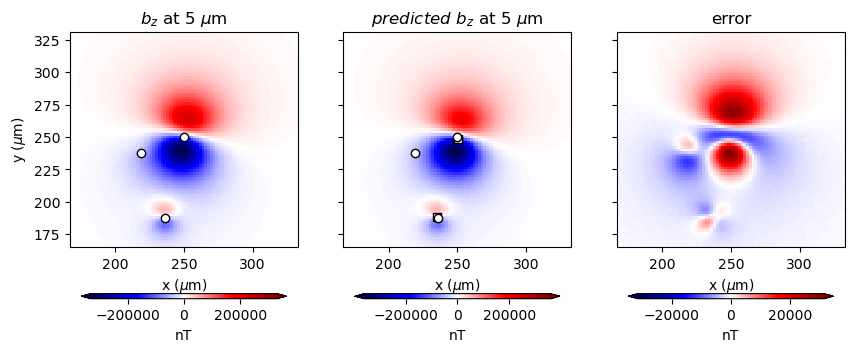

1
All modeled sources: R2 = 0.9911639147964662 and SNR = 20.537780075031463


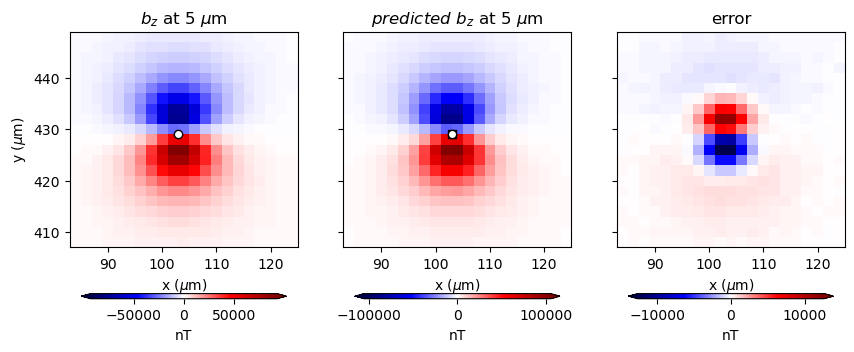

2
All modeled sources: R2 = 0.9899466920448767 and SNR = 21.674885684496303


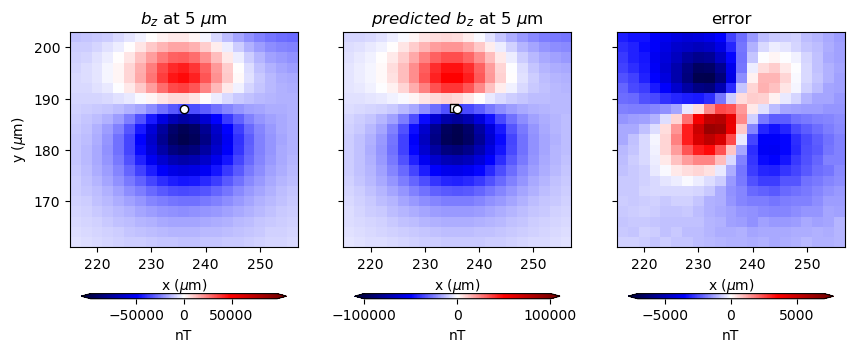

3
All modeled sources: R2 = 0.9994340320609982 and SNR = 32.6514142212541


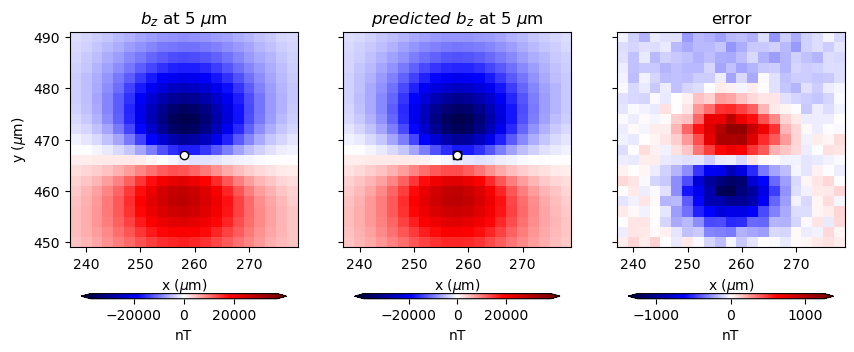

4
All modeled sources: R2 = 0.9989955310976627 and SNR = 30.27602481598408


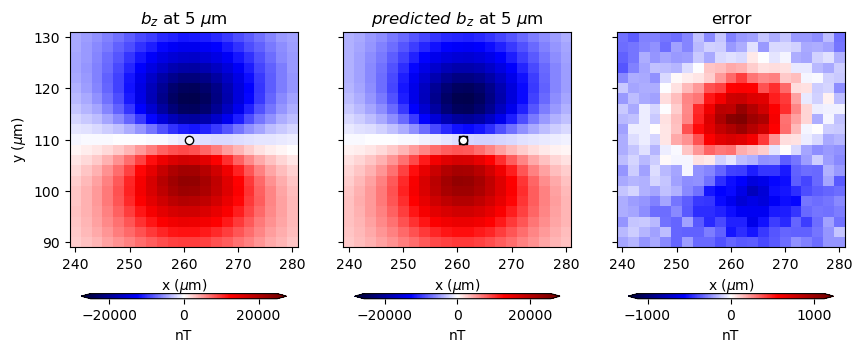

5
All modeled sources: R2 = 0.999538991549137 and SNR = 33.38257820106152


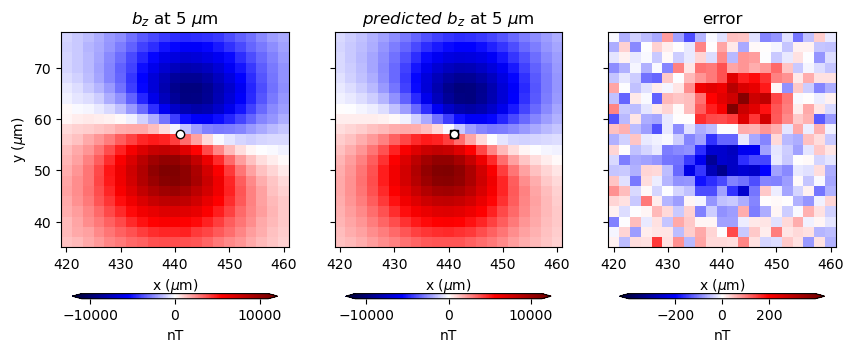

6
All modeled sources: R2 = 0.9972270072254809 and SNR = 25.92978540600164


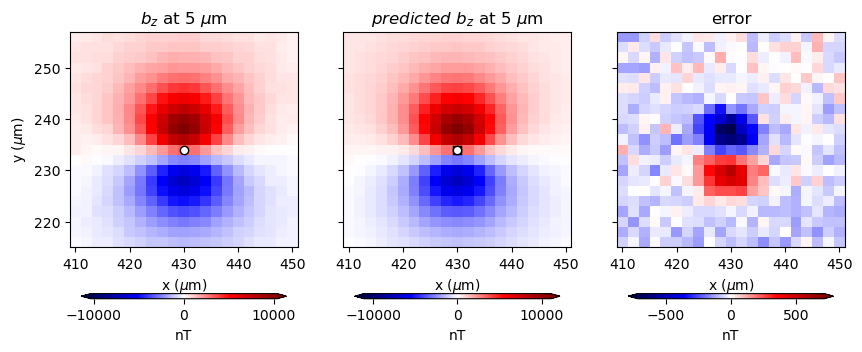

7
All modeled sources: R2 = 0.9987645205816549 and SNR = 29.85934403174732


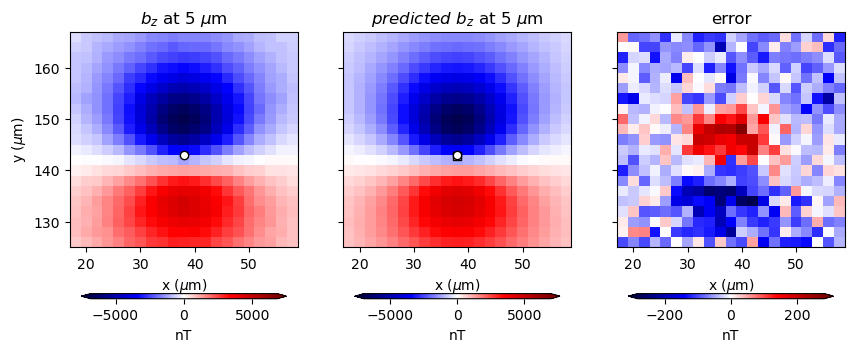

8
All modeled sources: R2 = 0.9913484946468814 and SNR = 22.25858203654886


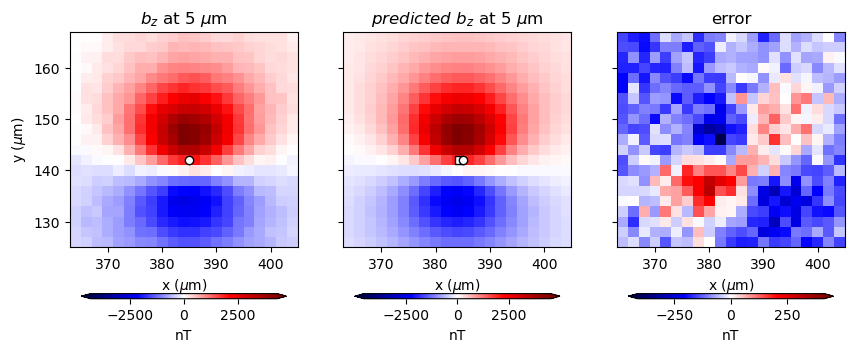

9
All modeled sources: R2 = 0.996489732716754 and SNR = 25.84350550716788


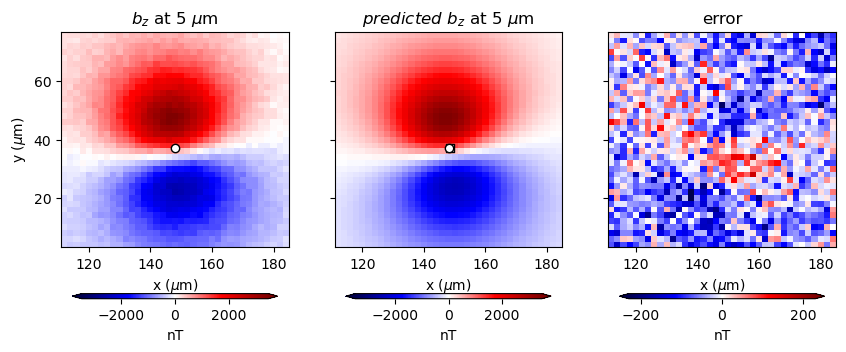

In [54]:
i = 0
for window in (windows_filtered):
    print(i)
    i += 1
    
    local_data = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9)
    
    ax = axes[0]
    ax.set_aspect("auto")
    ax.set_title(f"$b_z$ at {sensor_sample_distance:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = local_data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    ax.scatter(dipole_coordinates[0], dipole_coordinates[1], color='w', marker='o', edgecolors='k')
    
    ax = axes[1]
    ax.set_aspect("auto")
    ax.set_title(f"$predicted~b_z$ at {sensor_sample_distance:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = local_data.predicted_data.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    ax.scatter(all_positions[0], all_positions[1], color='w', marker='s', edgecolors='k')
    ax.scatter(dipole_coordinates[0], dipole_coordinates[1], color='w', marker='o', edgecolors='k')
    
    ax = axes[2]   
    ax.set_aspect("auto")
    ax.set_title("error")
    ax.set_xlabel("x ($\mu$m)")
    
    tmp = local_data.error.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
    residuals_sum_sq = np.sum((local_data.error.values)**2)
    r2_window = 1 - residuals_sum_sq / np.linalg.norm( np.array(local_data.bz.values) - float(local_data.bz.mean()) ) ** 2
    
    SNR_window = 10 * np.log10(np.var(local_data.bz.values, ddof=1) / np.var(local_data.error.values, ddof=1))
    
    # Compare R2 and SNR calculated with isolated windows and after calculating all sources contribution
    print(r"All modeled sources: R2 = %s and SNR = %s"%(r2_window, SNR_window))

    plt.show()